In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv('data_final_outli.csv')
pd.set_option('display.max_columns', None)
data.drop(['Unnamed: 0','country_name', 'operation', 'title', 'title2', 'largo_description'], axis=1,inplace=True)
# data.head(2)

In [3]:
#limpio unos outliers en superficie cubierta

mask = data['surface_covered_in_m2_clean'] > 3000 #5000
data= data.loc[~mask]
# data.shape

mask_2 = data['surface_covered_in_m2_clean'] <= 20
data= data.loc[~mask_2]

mask_4 = data['price_usd_per_m2_clean'] > 6000
data= data.loc[~mask_4]

mask_5 = data['price_usd_per_m2_clean'] < 50
data= data.loc[~mask_5]

In [4]:
# a = data['surface_covered_in_m2_clean'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# print(a)

In [5]:
# data.sort_values('ambientes', ascending = True).head(1)

# data.sort_values('price_usd_per_m2_clean', ascending = True).head(5)

#> 7000 lo vuelo < que 10 

In [6]:
#elimino casos extremos en ambientes
data.loc[data['ambientes']>30] = np.NaN
print(data.loc[data['ambientes']>30].shape)
data.dropna(subset=['ambientes'],inplace=True)

#dropeo superficie cubierta que da por muy fuera del rango

# Genero una variable de barrio para CABA:

# data.drop('Barrio_CABA', axis=1, inplace=True)
data['Barrio_CABA']=data.loc[data['state_name']=='Capital Federal','barrio']
data.loc[(data['place_name']=='Capital Federal') & (data['state_name']=='Capital Federal'),'Barrio_CABA']= 'CABA - Sin barrio'
data['Barrio_CABA'].fillna('N.A', inplace=True)
data['Barrio_CABA']=data['Barrio_CABA'].replace({'Palermo Hollywood':'Palermo','Palermo Chico':'Palermo','Palermo Viejo':'Palermo','Palermo Soho':'Palermo', 'Las Cañitas': 'Palermo','Villa Lugano':'Villa Lugano', 'Villa Riachuelo': 'Villa Lugano','Villa Soldati':'Villa Lugano','Villa Soldati':'Villa Lugano','Barracas':'Barracas','Pompeya':'Barracas','Parque Patricios':'Barracas','Villa Luro':'Villa Luro','Liniers':'Flores','Versalles':'Villa Luro','Monte Castro':'Villa Luro','Villa Real':'Villa Luro','Velez Sarsfield':'Floresta','Flores':'Flores','Villa General Mitre':'Villa Santa Rita','San Cristobal':'Boedo','Parque Chas':'Parque Chas','Villa Ortuzar':'Parque Chas','Coghlan':'Villa Urquiza','Villa Urquiza':'Villa Urquiza','Once':'Balvanera','Tribunales':'San Nicolás', 'Catalinas': 'Retiro', 'Nuñez':'Belgrano', 'Barrio Norte': 'Recoleta', 'Abasto':'Almagro', 'Centro / Microcentro': 'San Nicolás'})
data['Barrio_CABA'].unique()

# Reemplazo State_name con Barrio CABA
data['zona']=data['state_name']
data.loc[data['zona']=='Capital Federal','zona']=data.loc[data['zona']=='Capital Federal','Barrio_CABA']

#abrimos zona norte en 2
data.loc[(data['zona']=='Bs.As. G.B.A. Zona Norte') & ((data['partido']=='General San Martín') | (data['partido']=='José C Paz') | (data['partido']=='San Miguel')),'zona']= 'Bs.As. G.B.A. Zona Noroeste'

data.loc[(data['partido']=='Tigre'),'zona']='Tigre'
data.loc[(data['partido']=='Tigre'),'zona']='Tigre'
data.loc[(data['partido']=='Vicente López'),'zona']='Vicente López'
data.loc[(data['partido']=='Pilar'),'zona']='Pilar'
data.loc[(data['partido']=='San Isidro'),'zona']='San Isidro'
data.loc[(data['partido']=='Escobar'),'zona']='Escobar'

data = data.reset_index()


(0, 52)


In [7]:
#colpso categorias basado en ubicacion geografica y precio promedio uds por m2
lista_1 = ['Formosa','Chaco', "Santiago Del Estero", "Jujuy" ]
lista_2 = ['San Juan', "La Rioja",'Catamarca', 'La Pampa']

for i in range(0,len(data)):
        if (data.loc[i,"zona"] in lista_1):
             data.loc[i,"zona"] = "NORTE_CENTRO"
        elif (data.loc[i,"zona"] in lista_2):
             data.loc[i,"zona"] = "CUYO_PAMPA"
        else:
            data.loc[i,"zona"] = data.loc[i,"zona"]

In [8]:
data["state_avg_price"] =  data[["price_usd_per_m2_clean", "zona", 'property_type']].groupby(by =["zona", 'property_type'], dropna=True).transform("mean")
data["state_max_price"] =  data[["price_usd_per_m2_clean", "zona", 'property_type']].groupby(by =["zona", 'property_type'], dropna=True).transform("max")
data["state_min_price"] =  data[["price_usd_per_m2_clean", "zona", 'property_type']].groupby(by =["zona", 'property_type'], dropna=True).transform("min")

In [9]:
data["surface_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type']].groupby(by =["zona", 'property_type'], dropna=True).transform("mean")
data["surface_max_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type']].groupby(by =["zona", 'property_type'], dropna=True).transform("max")
data["surface_min_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type']].groupby(by =["zona", 'property_type'], dropna=True).transform("min")

In [10]:
data["price_amb_avg_price"] =  data[["price_usd_per_m2_clean", "zona", 'property_type', 'ambientes']].groupby(by =["zona", 'property_type', 'ambientes'], dropna=True).transform("mean")
data["price_amb_max_price"] =  data[["price_usd_per_m2_clean", "zona", 'property_type', 'ambientes']].groupby(by =["zona", 'property_type', 'ambientes'], dropna=True).transform("max")
data["price_amb_min_price"] =  data[["price_usd_per_m2_clean", "zona", 'property_type', 'ambientes']].groupby(by =["zona", 'property_type', 'ambientes'], dropna=True).transform("min")

In [11]:
data["sup_amb_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes']].groupby(by =["zona", 'property_type', 'ambientes'], dropna=True).transform("mean")
data["sup_amb_max_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes']].groupby(by =["zona", 'property_type', 'ambientes'], dropna=True).transform("max")
data["sup_amb_min_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes']].groupby(by =["zona", 'property_type', 'ambientes'], dropna=True).transform("min")

In [12]:
data["sup_parrilla_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes', 'parrilla']].groupby(by =["zona", 'property_type', 'ambientes',  'parrilla'], dropna=True).transform("mean")
data["sup_seguridad_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes','seguridad']].groupby(by =["zona", 'property_type', 'ambientes', 'seguridad'], dropna=True).transform("mean")
data["sup_estre_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes','a_estrenar']].groupby(by =["zona", 'property_type', 'ambientes', 'a_estrenar'], dropna=True).transform("mean")
data["sup_balcon_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes','balcon']].groupby(by =["zona", 'property_type', 'ambientes', 'balcon'], dropna=True).transform("mean")
data["sup_terraza_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type','ambientes', 'terraza']].groupby(by =["zona", 'property_type', 'ambientes', 'terraza'], dropna=True).transform("mean")
data["sup_pileta_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type','ambientes', 'pileta']].groupby(by =["zona", 'property_type', 'ambientes', 'pileta'], dropna=True).transform("mean")
data["sup_jardin_avg_price"] =  data[["surface_covered_in_m2_clean", "zona", 'property_type', 'ambientes','jardin']].groupby(by =["zona", 'property_type', 'ambientes', 'jardin'], dropna=True).transform("mean")

In [13]:
data.head(1)

,index,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,description,price_usd_clean,price_clean,currency_clean,price_local_currency_clean,surface_total_in_m2_clean,surface_covered_in_m2_clean,surface_total_in_m2_regex,surface_covered_in_m2_regex,rooms_regex,ambientes,ambientes_regex,clean_floor,price_usd_per_m2_clean,price_per_m2_clean,surface_total_log,surface_covered_log,seguridad,jardin,a_estrenar,balcon,terraza,parrilla,pileta,cochera,lago,lavadero,sum,place_type,provincia,ciudad,barrio,partido,Barrio_CABA,zona,state_avg_price,state_max_price,state_min_price,surface_avg_price,surface_max_price,surface_min_price,price_amb_avg_price,price_amb_max_price,price_amb_min_price,sup_amb_avg_price,sup_amb_max_price,sup_amb_min_price,sup_parrilla_avg_price,sup_seguridad_avg_price,sup_estre_avg_price,sup_balcon_avg_price,sup_terraza_avg_price,sup_pileta_avg_price,sup_jardin_avg_price
0,0,house,Tigre,|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|,Bs.As. G.B.A. Zona Norte,3427753.0,"-34.3782959,-58.69849014",-34.378296,-58.69849,NaN,NaN,NaN,NaN,316.0,263.0,NaN,NaN,NaN,3.0,NaN,Hermosa casa a la laguna en uno de los mejores...,457000.0,457000.0,USD,8063536.5,316.0,263.0,0.0,0.0,2.0,3.0,3.0,NaN,1446.202532,1446.202532,5.755742,5.572154,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,partido,Buenos Aires,N.A,N.A,Tigre,N.A,Tigre,1336.512941,2888.888889,50.0,249.730286,2100.0,25.0,1326.705613,2880.0,86.111111,234.65645,1094.376654,25.0,234.254219,220.943762,237.160596,233.961863,270.897772,259.889498,229.734597


In [14]:
cols = ["state_avg_price", "state_max_price", "state_min_price"]

for i in cols:
    data[i+"squared"]=np.power(data[i], 2)
    data[i+"squared"]=np.power(data[i], 3)
    data[i+"log"] =np.log(data[i])
    data[i+"sqrt"] =np.sqrt(data[i])

In [15]:
cols = ["surface_avg_price", "surface_max_price", "surface_min_price"]

for i in cols:
    data[i+"squared"]=np.power(data[i], 2)
    data[i+"squared"]=np.power(data[i], 3)
    data[i+"sqrt"] =np.sqrt(data[i])

In [16]:
#ESTO SE USO PARA ESTIMAR LA REGRESION

# X_reg = data['ambientes']
# y_reg = data['price_usd_per_m2_clean']



# X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size = 0.3)

# X_reg = sm.add_constant(X_reg)

# # X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

# model_1 = sm.OLS(y_train, X_train).fit()
# predictions = model_1.predict(X_test)
# predictions_test = model_1.predict(X_test)
# residuals = model_1.resid

# # print ("EMC:", mean_squared_error(y, predictions))
# # print (model_1.summary())
# print(model_1.summary())


In [17]:
#creo esta varaible biendo como cae el precio por m2 en base al numero de ambientes
 
for i in range(len(data)):
    data['reg_scatter']=''
    data.loc[i,'price_amb_log_scatter'] = 6000 - 415.51 * data.loc[i, 'ambientes']

In [18]:
# creo interacciones

data['ambientes_inversa'] = 1/data['ambientes']
data['ambientes_log'] = np.log(data['ambientes'])
data['ambientes_sqrt'] = np.sqrt(data['ambientes'])

# data['price_m2_ambientes'] = data['price_usd_per_m2_clean']/data['ambientes']

data['surface_inversa'] = 1/data['surface_covered_in_m2_clean']
data['surface_log'] = np.log(data['surface_covered_in_m2_clean'])
data['surface_sqrt'] = np.sqrt(data['surface_covered_in_m2_clean'])


data["interaccion_1"]=data["surface_covered_in_m2_clean"]*data["jardin"]
data["interaccion_2"]=data["surface_covered_in_m2_clean"]*data["a_estrenar"]
data["interaccion_3"]=data["surface_covered_in_m2_clean"]*data["balcon"]
data["interaccion_4"]=data["surface_covered_in_m2_clean"]*data["terraza"]
data["interaccion_5"]=data["surface_covered_in_m2_clean"]*data["parrilla"]
data["interaccion_6"]=data["surface_covered_in_m2_clean"]*data["pileta"]
data["interaccion_7"]=data["surface_covered_in_m2_clean"]*data["cochera"]
data["interaccion_8"]=data["surface_covered_in_m2_clean"]*data["ambientes"]
data["interaccion_9"]=data["ambientes"]*data["jardin"]
data["interaccion_10"]=data["ambientes"]*data["a_estrenar"]
data["interaccion_11"]=data["ambientes"]*data["balcon"]
data["interaccion_12"]=data["ambientes"]*data["terraza"]
data["interaccion_13"]=data["ambientes"]*data["parrilla"]
data["interaccion_14"]=data["ambientes"]*data["pileta"]
data["interaccion_15"]=data["ambientes"]*data["cochera"]
data["interaccion_|6"]=data["state_avg_price"]*data["jardin"]
data["interaccion_17"]=data["state_avg_price"]*data["a_estrenar"]
data["interaccion_18"]=data["state_avg_price"]*data["balcon"]
data["interaccion_19"]=data["state_avg_price"]*data["terraza"]
data["interaccion_20"]=data["state_avg_price"]*data["parrilla"]
data["interaccion_21"]=data["state_avg_price"]*data["pileta"]
data["interaccion_22"]=data["state_avg_price"]*data["cochera"]

In [19]:
# data['price_amb_log_scatter'].head(2)

In [20]:

# data_model= data[['property_type','zona', 'state_max_price', 'state_min_price', 'state_avg_price', 'surface_avg_price', 'surface_min_price', 'surface_max_price','seguridad','jardin','a_estrenar','balcon','terraza','parrilla','pileta','cochera', 'lavadero', 'sum', 'lago', 'interaccion_2', 'interaccion_6', 'interaccion_3','state_max_pricelog', 'state_avg_pricelog', 'state_min_pricesquared', 'state_max_pricesquared', 'surface_avg_pricesqrt', 'división_datos_precio', 'state_avg_pricesquared', 'state_avg_pricelog', 'surface_avg_pricesqrt',
#                   'ambientes_sqrt', 'ambientes_inversa', 'ambientes_log', 'surface_inversa', 'surface_log', 'surface_sqrt', 'price_amb_avg_price', 'price_amb_min_price', 'price_amb_max_price','sup_amb_avg_price', 'sup_amb_min_price', 'sup_amb_max_price', 'price_amb_log_scatter',"sup_parrilla_avg_price","sup_seguridad_avg_price","sup_estre_avg_price","sup_balcon_avg_price" ,"sup_terraza_avg_price","sup_pileta_avg_price" ,"sup_jardin_avg_price" ]]

# 'lago', 'zona_tucuman'

data_model= data[['property_type','zona', 'seguridad','jardin','a_estrenar','balcon','terraza','parrilla','pileta','cochera', 
                  'ambientes_sqrt', 'ambientes_inversa', 'ambientes_log', 'surface_inversa', 'surface_log', 'surface_sqrt' ]]


# 'surface_inversa',price_amb_avg_price

target=data["price_usd_per_m2_clean"]

dummy_correct = pd.get_dummies(data_model, drop_first=True)

#estas variables quedan luego de hacer feature selection viendo los valores de p-value con cada test de sginification indiviual y volviendo a correr el modelo, quitando varaibles
# por multicolinealidad, viendo el vif cercano a uno de todas las varaibles y terminando de validar con Lasso CV. 

# dummy_correct_2 = dummy_correct[[ 'seguridad', 'jardin', 'a_estrenar', 'balcon', 'pileta', 'cochera',
#                                    'lavadero', 'lago', 'división_datos_precio', 'price_amb_avg_price',
#                                    'zona_Misiones', 'zona_Salta', 'zona_Santa Fe', 'zona_Tucumán']]

dummy_correct_2 = dummy_correct[[ 'seguridad', 'jardin', 'a_estrenar',  'pileta',
       'cochera','surface_inversa',
       'property_type_apartment','property_type_store', 'zona_Almagro',
       'zona_Barracas', 'zona_Belgrano', 'zona_Boca', 
       'zona_Bs.As. G.B.A. Zona Noroeste',
       'zona_Bs.As. G.B.A. Zona Oeste', 'zona_Bs.As. G.B.A. Zona Sur',
       'zona_Buenos Aires Costa Atlántica', 'zona_Buenos Aires Interior',
       'zona_CABA - Sin barrio', 'zona_Caballito', 'zona_Chacarita',
       'zona_Chubut', 'zona_Colegiales', 'zona_Constitución',
       'zona_Córdoba', 'zona_Entre Ríos',
       'zona_Escobar', 'zona_Mendoza', 'zona_Misiones',
       'zona_NORTE_CENTRO', 'zona_Neuquén', 'zona_Palermo',
       'zona_Parque Centenario', 'zona_Parque Chas', 'zona_Pilar',
       'zona_Puerto Madero', 'zona_Recoleta', 'zona_Retiro',
       'zona_Saavedra', 'zona_Salta', 'zona_San Isidro', 'zona_San Luis',
       'zona_San Nicolás', 'zona_San Telmo', 'zona_Santa Cruz',
       'zona_Santa Fe', 'zona_Tierra Del Fuego', 'zona_Tigre',
       'zona_Tucumán', 'zona_Vicente López', 'zona_Villa Crespo',
       'zona_Villa Devoto', 'zona_Villa Lugano', 'zona_Villa Luro',
       'zona_Villa Pueyrredón', 'zona_Villa Santa Rita',
       'zona_Villa Urquiza', 'zona_Villa del Parque']]

X = dummy_correct
y = target

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

regr = LinearRegression()
  
regr.fit(X_train, y_train)

print(regr.score(X_train, y_train))
print(regr.score(X_test, y_test))

0.6457416890927181
0.6452904126053103


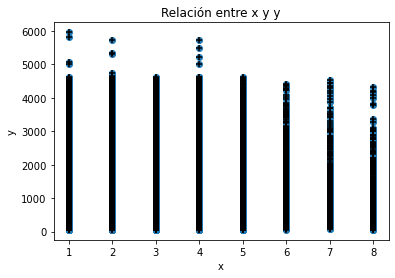

In [22]:
#chequeo de los supuestos

X= data['ambientes']
y=data[["price_usd_per_m2_clean"]]
# Graficamos la variable X contra la variable Y
plt.scatter(X, y, s=30, c='black', marker='+', zorder=10)
plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Relación entre x y y')
plt.show()

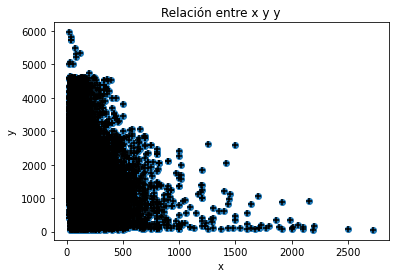

In [23]:
#chequeo de los supuestos

X= data['surface_covered_in_m2_clean']
y=data[["price_usd_per_m2_clean"]]
# Graficamos la variable X contra la variable Y
plt.scatter(X, y, s=30, c='black', marker='+', zorder=10)
plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Relación entre x y y')
plt.show()

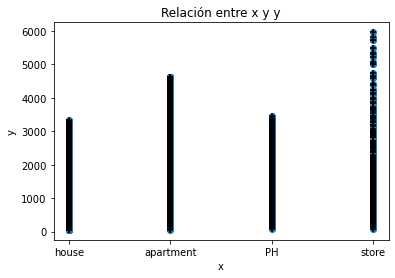

In [24]:
#chequeo de los supuestos

X= data['property_type']
y=data[["price_usd_per_m2_clean"]]
# Graficamos la variable X contra la variable Y
plt.scatter(X, y, s=30, c='black', marker='+', zorder=10)
plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y")
plt.title('Relación entre x y y')
plt.show()

In [25]:
# Importamos la api:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [26]:
m_corr=data[['seguridad','jardin','a_estrenar','balcon','terraza','parrilla','pileta','cochera','ambientes','partido']]

# matriz de correlación:
m_corr.corr()

,seguridad,jardin,a_estrenar,balcon,terraza,parrilla,pileta,cochera,ambientes
seguridad,1.000000,-0.018979,0.016810,0.059440,0.063103,0.131012,0.274064,0.157234,0.029896
jardin,-0.018979,1.000000,-0.108907,-0.056406,0.035683,0.054470,0.010028,-0.031488,0.180996
a_estrenar,0.016810,-0.108907,1.000000,0.065425,0.028667,0.056941,0.020238,0.095959,-0.176296
balcon,0.059440,-0.056406,0.065425,1.000000,0.117322,-0.006501,0.006103,0.090099,-0.081410
terraza,0.063103,0.035683,0.028667,0.117322,1.000000,0.175158,0.091910,0.126847,0.023369
parrilla,0.131012,0.054470,0.056941,-0.006501,0.175158,1.000000,0.385351,0.118634,0.098811
pileta,0.274064,0.010028,0.020238,0.006103,0.091910,0.385351,1.000000,0.161205,0.094823
cochera,0.157234,-0.031488,0.095959,0.090099,0.126847,0.118634,0.161205,1.000000,0.002056
ambientes,0.029896,0.180996,-0.176296,-0.081410,0.023369,0.098811,0.094823,0.002056,1.000000


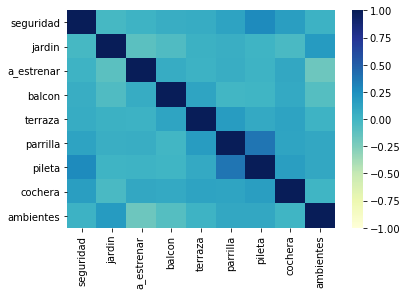

In [27]:
#grafico:
sns.heatmap(m_corr.corr(), vmin=-1, vmax=1, center=0, cmap="YlGnBu");

In [28]:
#TRANSFORMACION DE BOX Y COX PARA LA HOMOCEDASTICIDAD Y LINEALIDAD DE LOS RESIDUOS Y ESCALAMIENTO DE VARAIBLES

from scipy import stats   
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

y = target

fitted_data, fitted_lambda = stats.boxcox(y) 

#y entonces pasaria a ser fitted_data

print(f"Lambda value used for Transformation: {fitted_lambda}")


scaler = StandardScaler()
dummy_correct_scaled = scaler.fit_transform(dummy_correct_2)


Lambda value used for Transformation: 0.6001547929474289


In [29]:
dummy_correct_scaled = pd.DataFrame(dummy_correct_scaled, columns = dummy_correct_2.columns)

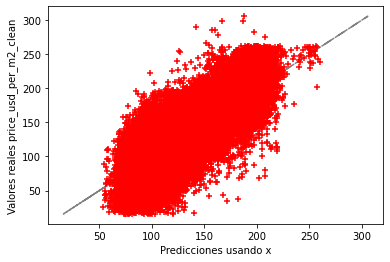

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     1364.
Date:                Thu, 17 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:09:25   Log-Likelihood:            -2.1891e+05
No. Observations:               46000   AIC:                         4.379e+05
Df Residuals:                   45942   BIC:                         4.385e+05
Df Model:                          57                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [30]:
# genero el modelo con sm

# X = dummy_correct_scaled
y = fitted_data

X = dummy_correct_2
# y = target

#ACA SE PUEDE PONER Y=FITTED_DATA (COMENTADO MAS ARRIBA) EN VEZ DE TARGET PARA QUE MEJORE UN POQUITO MEJOR EL QQPLOT Y EL GRAFICO DE RESIDUOS, PERO SE PIERDEN 3 PUNTOS DE R2 ADJ

# y = target
#Tenemos que agregar explícitamente a una constante:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1, test_size=0.3)

model = sm.OLS(y_train, X_train).fit()
predictions = model.predict(X_train)
predictions_test = model.predict(X_test)
residuals = model.resid

# Graficamos los resultados
plt.plot(y_train,y_train, '-.', c='grey')
plt.scatter(predictions, y_train, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones usando x")
plt.ylabel("Valores reales price_usd_per_m2_clean")
plt.show()

# Imprimimos el MSE y un resumen del modelo
# print ("EMC:", mean_squared_error(y, predictions))
print (model.summary())

### Repaso de los supuestos de Gauss-Markov

1. El modelo es lineal en los parámetros.
2. Los estimadores de los parámetros poblacionales se estiman a partir de una muestra aleatoria.
3. No hay colinealidad perfecta entre las variables explicativas.
4. El valor esperado del error es 0 para cualquier valor de la variable explicativa.
5. Para cualquier valor de la variable explicativa, el error tienen la misma varianza (homocedasticidad).
6. El error es independiente de las variables explicativas y se distribuye normalmente.
$\epsilon \sim N (0,\sigma_\epsilon)$
7. No existe autocorrelación entre los errores de dos observaciones diferentes condicionadas a X.
$Cov(\epsilon_i,\epsilon_h|X)=0$


### Linealidad del modelo.
Para detectar la falta de linealidad, se pueden inspeccionar gráficas de valores observados frente a valores pronosticados o residuales frente a valores predichos. El resultado deseado es que los puntos se distribuyen simétricamente alrededor de una línea diagonal en la primera gráfica o alrededor de una línea horizontal en la última. En ambos casos con una varianza aproximadamente constante.

Observar un patrón "inclinado" indica que el modelo comete errores sistemáticos cada vez que realiza predicciones inusualmente grandes o pequeñas. Cuando el modelo contiene muchas características, la no linealidad también se puede revelar mediante patrones sistemáticos en las gráficas de los residuos frente a las características individuales.

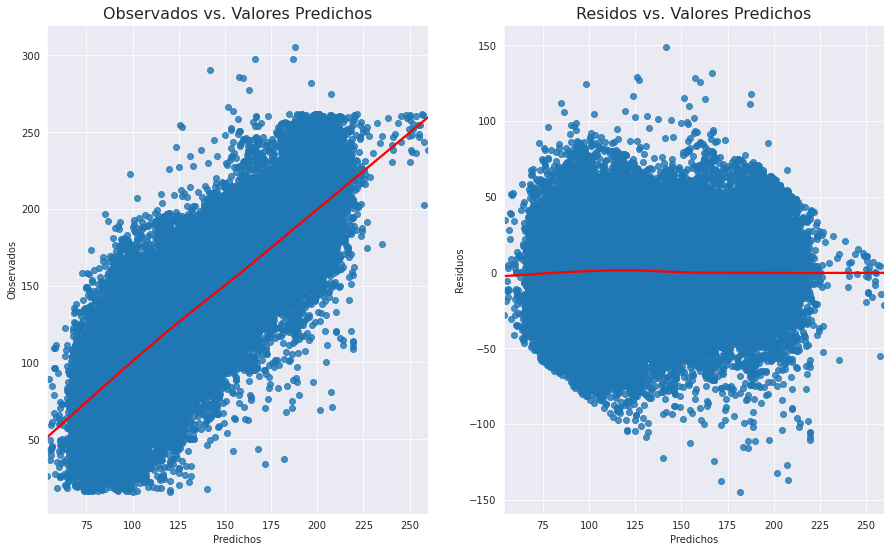

In [31]:
%matplotlib inline
#%config InlineBackend.figure_format ='retina'
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)

def linearity_test(modelo, y):
    '''
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = modelo.predict()
    resids = modelo.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observados vs. Valores Predichos', fontsize=16)
    ax[0].set(xlabel='Predichos', ylabel='Observados')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residos vs. Valores Predichos', fontsize=16)
    ax[1].set(xlabel='Predichos', ylabel='Residuos')
    
linearity_test(model, y_train)   

In [32]:
#Para detectar multicolinealidad poder utilizar el factor de inflación de varianza (VIF). Sin entrar en demasiados detalles, la interpretación de VIF es la siguiente: la raíz cuadrada de un VIF de una variable dada muestra cuánto más grande es el error estándar, en comparación con lo que sería si ese predictor no estuviera correlacionado con las otras características del modelo . Si no se correlacionan características, todos los valores para VIF serán 1.

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
X2 = dummy_correct_2
pd.DataFrame({'vif': vif[1:]}, index=X2.columns).T

,seguridad,jardin,a_estrenar,pileta,cochera,surface_inversa,property_type_apartment,property_type_store,zona_Almagro,zona_Barracas,zona_Belgrano,zona_Boca,zona_Bs.As. G.B.A. Zona Noroeste,zona_Bs.As. G.B.A. Zona Oeste,zona_Bs.As. G.B.A. Zona Sur,zona_Buenos Aires Costa Atlántica,zona_Buenos Aires Interior,zona_CABA - Sin barrio,zona_Caballito,zona_Chacarita,zona_Chubut,zona_Colegiales,zona_Constitución,zona_Córdoba,zona_Entre Ríos,zona_Escobar,zona_Mendoza,zona_Misiones,zona_NORTE_CENTRO,zona_Neuquén,zona_Palermo,zona_Parque Centenario,zona_Parque Chas,zona_Pilar,zona_Puerto Madero,zona_Recoleta,zona_Retiro,zona_Saavedra,zona_Salta,zona_San Isidro,zona_San Luis,zona_San Nicolás,zona_San Telmo,zona_Santa Cruz,zona_Santa Fe,zona_Tierra Del Fuego,zona_Tigre,zona_Tucumán,zona_Vicente López,zona_Villa Crespo,zona_Villa Devoto,zona_Villa Lugano,zona_Villa Luro,zona_Villa Pueyrredón,zona_Villa Santa Rita,zona_Villa Urquiza,zona_Villa del Parque
vif,1.136476,1.126264,1.05469,1.280371,1.122176,1.819152,2.061602,1.019861,1.130243,1.091583,1.354703,1.024514,1.308451,1.950742,1.969934,2.000652,1.189168,1.115581,1.233877,1.020434,1.023579,1.044119,1.023127,1.757763,1.01368,1.261957,1.040515,1.034686,1.005521,1.03052,1.38771,1.008675,1.015256,1.442192,1.013574,1.314815,1.030204,1.064029,1.011406,1.342015,1.022168,1.061866,1.097631,1.002458,1.473114,1.004757,2.047652,1.017338,1.391316,1.121839,1.053152,1.02785,1.066515,1.020728,1.014255,1.179467,1.055354


Normalidad de los errores.

Para cada valor 𝑥
, de la variable predictora 𝑋, la variable respuesta 𝑌 debe tener distribución Normal 𝜖∼𝑁(0,𝜎𝜖)

Usando el método ProbPlot vamos a graficar un QQplot para testear la normalidad de los residuos 

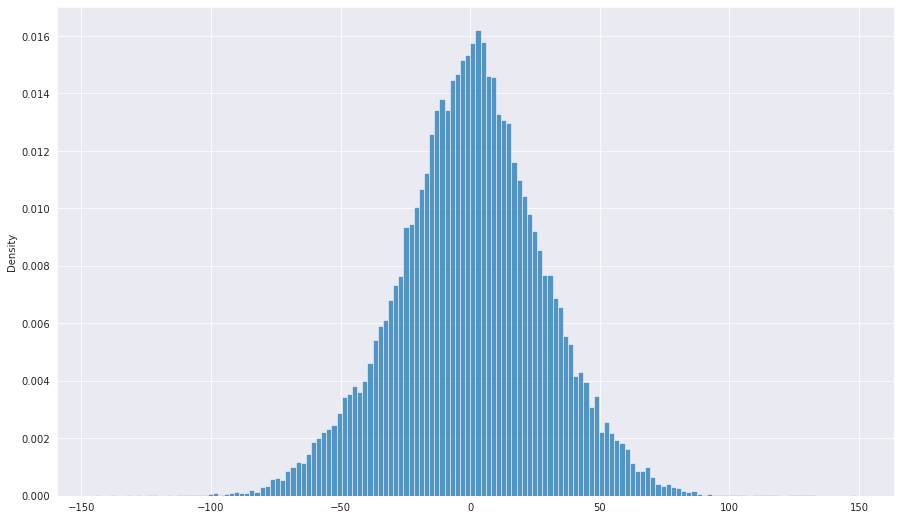

In [33]:
sns.histplot(residuals, kde = False, stat = 'density', line_kws={'linewidth':5});

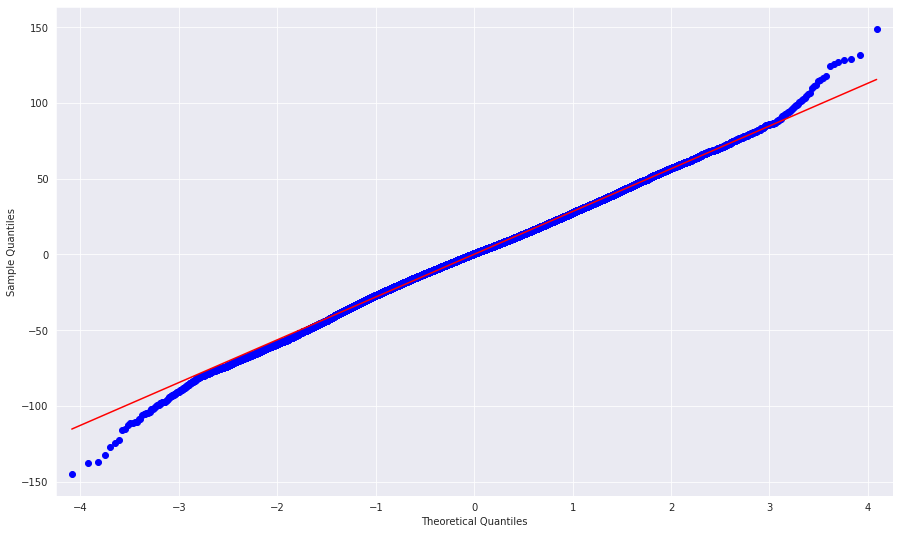

In [34]:
sm.ProbPlot(model.resid).qqplot(line='s');

In [35]:
# instanciamos un modelo RIDGE CROSS VALIDATION

from sklearn import linear_model

rlmcv = linear_model.RidgeCV(alphas=np.linspace(0.1,100, 1000), cv=10, normalize=True,scoring='r2')

rlmcv.fit(X_train, y_train)
predictions = rlmcv.predict(X_test)

print ("r^2:", rlmcv.score(X_test, y_test))

r^2: 0.6273081639561815


In [36]:
# instanciamos un modelo LASSO CROSS VALIDATION

lassocv = linear_model.LassoCV(alphas=np.linspace(0.01,100, 1000), cv=10, normalize=True)

lassocv.fit(X_train, y_train)
predictions = lassocv.predict(X_test)

print ("r^2:", lassocv.score(X_test, y_test))

r^2: 0.5670314755727073


In [37]:
print(rlmcv.coef_)

[  0.           5.70091232  -4.64330678   4.42659366   5.54356209
   7.64825021 709.90325015  34.36261898  24.82252076  12.44558666
   3.36767881  38.67850693 -11.47556289 -18.19226812 -15.80719469
  -7.57570797  -9.87234278 -26.55791392  -2.98255029  18.15912864
  13.12325411   9.4359614   26.00135465 -10.21752638 -29.90448851
 -28.86129258 -13.75090511 -23.47526397 -39.30710827 -33.45651741
  -6.68360314  42.66291154  18.29606593  18.37713977  -9.96705925
  83.72736935  42.89431059  31.29391768  16.35304919 -30.71074541
  17.02947328 -26.32693925   9.2445498    7.69965152 -19.51770983
 -20.84880017 -10.46793725   9.83799192 -40.66728794  28.65257531
  22.28820734  18.3925154  -15.94631484   8.31283174  18.10515376
  10.86089012  20.31759722  13.98185518]


In [38]:
print(lassocv.coef_)

[  0.           2.1643237   -0.78817076   0.           2.84480195
   4.26260997 362.73804008  43.94571266   1.70485921   0.
   0.          30.52634905  -0.          -5.61839141  -8.00612263
  -0.          -3.45832698 -11.06053299  -0.           5.67895178
   0.           0.           0.          -0.         -23.39493854
  -0.          -0.          -0.          -2.7571341   -0.
  -0.          36.14233998   0.           0.          -0.
  18.34988406  31.77785325   0.           0.          -0.
   8.43153169  -0.           0.           0.          -0.
 -11.28453118  -0.           7.39265287  -0.          22.00541524
   4.53308125   0.          -0.           0.           0.
   0.           7.45603826   0.        ]


In [39]:
coefficients = lassocv.coef_

importance = np.abs(coefficients)

np.array(X.columns)[importance > 0.01]

array(['seguridad', 'jardin', 'pileta', 'cochera', 'surface_inversa',
       'property_type_apartment', 'property_type_store', 'zona_Belgrano',
       'zona_Bs.As. G.B.A. Zona Noroeste',
       'zona_Bs.As. G.B.A. Zona Oeste',
       'zona_Buenos Aires Costa Atlántica', 'zona_Buenos Aires Interior',
       'zona_Caballito', 'zona_Córdoba', 'zona_Misiones', 'zona_Palermo',
       'zona_Puerto Madero', 'zona_Recoleta', 'zona_San Isidro',
       'zona_Santa Fe', 'zona_Tigre', 'zona_Vicente López',
       'zona_Villa Crespo', 'zona_Villa Urquiza'], dtype=object)

In [40]:
#usando lasso me quedo con las siguientes features

coefficients = rlmcv.coef_

importance = np.abs(coefficients)

np.array(X.columns)[importance > 0.01]

array(['seguridad', 'jardin', 'a_estrenar', 'pileta', 'cochera',
       'surface_inversa', 'property_type_apartment',
       'property_type_store', 'zona_Almagro', 'zona_Barracas',
       'zona_Belgrano', 'zona_Boca', 'zona_Bs.As. G.B.A. Zona Noroeste',
       'zona_Bs.As. G.B.A. Zona Oeste', 'zona_Bs.As. G.B.A. Zona Sur',
       'zona_Buenos Aires Costa Atlántica', 'zona_Buenos Aires Interior',
       'zona_CABA - Sin barrio', 'zona_Caballito', 'zona_Chacarita',
       'zona_Chubut', 'zona_Colegiales', 'zona_Constitución',
       'zona_Córdoba', 'zona_Entre Ríos', 'zona_Escobar', 'zona_Mendoza',
       'zona_Misiones', 'zona_NORTE_CENTRO', 'zona_Neuquén',
       'zona_Palermo', 'zona_Parque Centenario', 'zona_Parque Chas',
       'zona_Pilar', 'zona_Puerto Madero', 'zona_Recoleta', 'zona_Retiro',
       'zona_Saavedra', 'zona_Salta', 'zona_San Isidro', 'zona_San Luis',
       'zona_San Nicolás', 'zona_San Telmo', 'zona_Santa Cruz',
       'zona_Santa Fe', 'zona_Tierra Del Fuego', 'zon